In [1]:
from src.kernel.timeline import Timeline
from src.components.optical_channel import ClassicalChannel
from src.kernel.event import Event
from src.kernel.process import Process
from src.topology.node import raman_receiver_node, raman_sender_node
from src.topology.node import PULSE_BSMNode, raman_sender_node
from src.entanglement_management.raman_protocols import RamanTestReceiver
from matplotlib import pyplot as plt
import traceback
import numpy as np
import os
from datetime import datetime

ModuleNotFoundError: No module named 'src'

In [2]:
def init_experiment_setup(params):
    sender1 = raman_sender_node("PULSE_Quantum_Router_1", params["tl"], params["num_iterations"], params["clock_power"], params("narrow_band_filter_bandwidth"], params["quantum_channel_wavelength"], 
                               params["mean_photon_num"], params["is_distinguishable"], params["pulse_separation"], params["batch_size"], params["pulse_width"])
    sender2 = raman_sender_node("PULSE_Quantum_Router_3", params["tl"], params["num_iterations"], params["clock_power"], params["narrow_band_filter_bandwidth"], params["quantum_channel_wavelength"], 
                               params["mean_photon_num"], params["is_distinguishable"], params["pulse_separation"], params["batch_size"], params["pulse_width"])
    
    receiver = PULSE_BSMNode("PULSE_BSM_2", params["tl"], ['sender1', "sender2"])
    # idler_receiver = PULSE_BSM("idler_receiver", params["tl"], 'sender', params["collection_probability"], params["dark_count_rate"], params["dead_time"], params["time_resolution"])

    receiver_protocol = RamanTestReceiver(receiver, params["pulse_separation"])

    # signal_receiver.attach_detector_to_receiver(receiver_protocol)
    receiver.attach_detector_to_receiver(receiver_protocol)
    sender1.attach_lightsource_to_receivers("receiver")
    sender2.attach_lightsource_to_receivers("receiver")


    Qchannel1 = PULSE_QuantumChannel("Qchannel1", params["tl"], params["quantum_channel_attenuation"], params["classical_channel_attenuation"], params["distance"], params["raman_coefficient"], 
                                    params["polarization_fidelity"], params["light_speed"], params["max_rate"], params["quantum_channel_wavelength"], params["classical_channel_wavelength"], window_size = params["window_size"])
    Qchannel2 = PULSE_QuantumChannel("Qchannel2", params["tl"], params["quantum_channel_attenuation"], params["classical_channel_attenuation"], params["distance"], params["raman_coefficient"], 
                                    params["polarization_fidelity"], params["light_speed"], params["max_rate"], params["quantum_channel_wavelength"], params["classical_channel_wavelength"], window_size = params["window_size"])
    Cchannel1 = ClassicalChannel("Cchannel1", params["tl"], params["distance"])
    Cchannel2 = ClassicalChannel("Cchannel2", params["tl"], params["distance"])

    Qchannel1.set_ends(sender1, "receiver")
    Qchannel2.set_ends(sender2, "receiver")
    Cchannel1.set_ends(sender1, "receiver")
    Cchannel2.set_ends(sender2, "receiver")

    return sender1, sender2

In [3]:
experimental_parameters = {
    "tl" : Timeline(5000e12),

    # Parameters
    # Detector_parameters
    "collection_probability" : 10**(-1.2),
    "dark_count_rate" : 100, #100,
    "dead_time" : 25000,
    "time_resolution" : 50,

    # Optical channel
    "quantum_channel_attenuation" : 0.44,
    "classical_channel_attenuation" : 0.5,
    "distance" : 2,
    "raman_coefficient" : 33e-10,
    "polarization_fidelity" : 1,
    "light_speed" : 3e8,
    "max_rate" : 1e12,
    "quantum_channel_wavelength" : 1536e-9,
    "classical_channel_wavelength" : 1610e-9,
    "window_size" : 1e11,

    # Light Source
    # "wavelength" : quantum_channel_wavelength,
    "mean_photon_num" : 2, # 0.00316228, # 0.01
    "is_distinguishable" : True,
    "pulse_separation" : 5e3,
    "pulse_width" : 80,
    "batch_size" : 5000, # 50000000,
    "num_iterations" : 5, # 240, 600,

    # Clock parameters
    "clock_power" : 0.0003,
    "narrow_band_filter_bandwidth" : 0.03,
}

time of start: 2023-07-20 15:06:55.161534
scheduling Raman photon detection at Qchannel1
Raman photosns added 17940
<class 'int'>
emitting  now. Emission time is: 0
emitting  now. Emission time is: 12500
emitting  now. Emission time is: 25000
emitting  now. Emission time is: 37500
emitting  now. Emission time is: 50000
last emit time: 50000
<class 'int'>
emitting  now. Emission time is: 0
emitting  now. Emission time is: 12500
emitting  now. Emission time is: 25000
emitting  now. Emission time is: 37500
emitting  now. Emission time is: 50000
last emit time: 50000
Scheduling arrivals of Raman photons
Scheduling arrivals of Raman photons
Photon object created at sender1. sending over channel now. Photon number is: 4
in optical channel Qchannel1, sending photon with photon number 0
Photon object created at sender2. sending over channel now. Photon number is: 1
in optical channel Qchannel2, sending photon with photon number 0
Photon object created at sender1. sending over channel now. Phot

c:\Users\anshs\Desktop\study\Argonne\SeQUeNCe\SeQUeNCe\src\entanglement_management\raman_protocols.py:163: RuntimeWarning: invalid value encountered in true_divide
  CAR = matched_correlation/(sum(unmatched_correlations)/len(unmatched_correlations))
c:\Users\anshs\Desktop\study\Argonne\SeQUeNCe\SeQUeNCe\src\entanglement_management\raman_protocols.py:168: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


CAR: nan


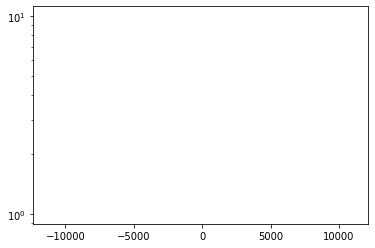

simulation ended at 2023-07-20 15:06:57.020519


In [4]:
try:
    now = datetime.now()
    print("time of start:", now)
    experimental_parameters["tl"] = Timeline(5000e12)
    # experimental_parameters["mean_photon_num"] = 0.01
    sender1, sender2 = init_experiment_setup(experimental_parameters)
    
    process1 = Process(sender1.protocol, "start", [True])
    event1 = Event(0, process1)
    experimental_parameters["tl"].schedule(event1)

    process2 = Process(sender2.protocol, "start", [False])
    event2 = Event(0, process2)
    experimental_parameters["tl"].schedule(event2)

    experimental_parameters["tl"].init()
    experimental_parameters["tl"].run()
    #     file = open("CAR_Data.txt")
    #     CAR_Data.append(list(map(float, file.readlines())))
    #     file.close()
    #     os.remove("CAR_Data.txt")
    # plt.boxplot(list(zip(*CAR_Data)))
    # plt.xticks(np.arange(num_samples)+1, np.logspace(min_mpn, max_mpn, num_samples))

        

    # print(signal_receiver.protocol.coincidence_times)
    
    # n, bins, patches = plt.hist(signal_receiver.protocol.detection_times, range(-28125, 28126, 6250))
    # plt.show() 
    print("simulation ended at", datetime.now())   
except Exception:
    print(traceback.format_exc())

try:
    CAR_Data = []
    for j in range(1):
        for i in np.linspace(-1.2,-1.8,5):
            print("I,j:", i, j)
            experimental_parameters["tl"] = Timeline(5000e12)
            experimental_parameters["collection_probability"] = 10**i
            sender = init_experiment_setup(experimental_parameters)
            process = Process(sender.protocol, "start", [])
            event = Event(0, process)
            experimental_parameters["tl"].schedule(event)

            experimental_parameters["tl"].init()
            experimental_parameters["tl"].run()
        file = open("CAR_Data.txt")
        CAR_Data.append(list(map(float, file.readlines())))
        file.close()
   
except Exception:
    print(traceback.format_exc())

len of temp_data: 2
[[nan, nan], [], []]


C:\Users\anshs\AppData\Local\Temp/ipykernel_25696/420326573.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


{'whiskers': [<matplotlib.lines.Line2D at 0x2e87733f640>,
 'caps': [<matplotlib.lines.Line2D at 0x2e87732e9d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2e87733fc70>],
 'medians': [<matplotlib.lines.Line2D at 0x2e87734b580>],
 'fliers': [<matplotlib.lines.Line2D at 0x2e87734bb20>],
 'means': [<matplotlib.lines.Line2D at 0x2e87734b850>]}

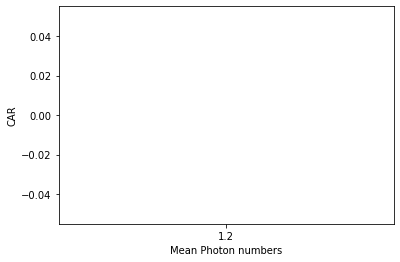

In [18]:
CAR_Data = []
temp_data = []
file = open("CAR_Data.txt")
temp_data.append(list(map(float, file.readlines())))
file.close()

print("len of temp_data:", len(temp_data[0]))

for i in range(3):
    CAR_Data.append(temp_data[0][i*5:(i+1)*5])

print(CAR_Data)

fig, ax = plt.subplots()
fig.canvas.draw()
labels = [str(i)[1:6] for i in np.linspace(-1.2,-1.8,5)]# [0.000562341,0.001,0.001778279,0.00316228,0.00562341,0.01,0.01778279,0.03162278,0.05623413,0.1]]
ax.set_xticklabels(labels)
ax.set_xlabel("Mean Photon numbers")
ax.set_ylabel("CAR")
plt.boxplot(list(zip(*CAR_Data)), meanline = True, showmeans=True, medianprops={"linewidth":0})

In [19]:
import numpy as np
a = np.array([123456788,234787359837,324782648923,4743287894279])
# b = np.array([5.,6.,7.,8.])
print(type(a[1]))
with open("temp.txt", "wb+") as fileID:
    fileID.write(a.data)
# fileID.close()

# fileID = open("temp.txt", "ab+")
# fileID.write(b.data)
# fileID.close()



<class 'numpy.int64'>


In [20]:
import time
a = np.array([])
start = time.time()
# a = np.random.rand(1000000)
for i in range(1000000):
    np.random.rand()
print("time taken:", time.time()-start)


time taken: 0.46305084228515625


In [1117]:

""" adds a photon train of noisy photons scattered from the classical band into the quantum band."""

h = 6.62607015 * 10**(-34)
c = 3 * 10**8
clock_power = 0.0003
raman_coefficient = 33e-10
narrow_band_filter_bandwidth = 0.3
attenuation = 0.1
classical_channel_attenuation = 7
quantum_channel_wavelength = 1536e-9

window_size = 6.66e6
pulse_width = 1e-5
distance = 2

raman_power = np.abs(clock_power * raman_coefficient * narrow_band_filter_bandwidth * (np.exp(-attenuation * pulse_width) - np.exp(-classical_channel_attenuation * pulse_width)) / (attenuation - classical_channel_attenuation))
raman_energy = raman_power * window_size/1e12
mean_num_photons = (raman_energy / (h * c / quantum_channel_wavelength))

num_photons_added = sum(np.random.poisson(mean_num_photons, 50000))
dAlpha = attenuation - classical_channel_attenuation
positions = []
# np.exp(distance * classical_channel_attenuation)
for i in range(num_photons_added):
    positions.append((1/dAlpha) * np.log((np.exp(distance * dAlpha) - 1) * np.random.rand() + 1))


print("max Position:", max(positions))
print("Raman photosns added", num_photons_added)

# photon_generation_times = np.random.rand(num_photons_added) * window_size

max Position: 0.3189550474392806
Raman photosns added 12


In [ ]:
import re
a = "sender_42"
print(re.find("_", a))

NameError: name 'i' is not defined

In [27]:
a = np.zeros((5,5))
a[:,0] = 1
a

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [1]:
from src.kernel.quantum_state import DensityState
from src.kernel.quantum_manager import QuantumManagerDensityFock
from src.kernel.timeline import Timeline
from src.components.light_source import SPDCSource
import numpy as np

qm = QuantumManagerDensityFock()
key1 = qm.new([1/np.sqrt(2),1/np.sqrt(2)])
key2 = qm.new([1,0])
for i in range(10000):
    a,b = qm._prepare_state([key2, key1])
# a.toarray()
# qm._generate_swap_operator(2, 0, 1)
# a = SPDCSource(None, Timeline(1e12))
# print()
# a = a._generate_tmsv_state()
# print(a)

# DensityState(a, [1,2])

In [19]:
import scipy.sparse as sp
import numpy as np
s = [1,2,3,4]
s = sp.csc_array(s)
s = s.T*s
print(s.toarray())
state = sp.csr_array([[1,2,3],[4,5,6],[7,8,9]])
# print(tuple(map(tuple, state)))
# print(tuple(zip(*state.nonzero())))
state = np.zeros((100,100))
state[:,0] = 1
state = sp.array(state)
tuple_state = []
for x,y in zip(*state.nonzero()):
    tuple_state.append((x, y, state[x,y]))
print(tuple(tuple_state))
# print(state.nonzero())
# print(state)

[[ 1  2  3  4]
 [ 2  4  6  8]
 [ 3  6  9 12]
 [ 4  8 12 16]]
((0, 0, 1), (0, 1, 2), (0, 2, 3), (1, 0, 4), (1, 1, 5), (1, 2, 6), (2, 0, 7), (2, 1, 8), (2, 2, 9))


In [9]:
from src.kernel.quantum_utils import density_partial_trace
import numpy as np
import scipy.sparse as sp
a = np.array([[1,0,0,0]])
a = a * a.T
print(a)
density_partial_trace(a, [0], 2)

import time
state = np.zeros((100,100))
state[:,0] = 1
state = sp.csr_array(state)
start = time.time()

for i in range(5000):
    # tuple_state = [[]]*len(state.nonzero()[0])
    # index = 0
    # for x,y in zip(*state.nonzero()):
    #     tuple_state[index] = (x, y, state[x,y])
    #     index += 1
    # tuple_state = state.toarray()
    # b = tuple(map(tuple, tuple_state))
    b = tuple(map(tuple, state))
print("time required:", time.time()-start)

[[1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
before, temp: [[1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
temp reshaped matrix [[[[1 0]
   [0 0]]

  [[0 0]
   [0 0]]]


 [[[0 0]
   [0 0]]

  [[0 0]
   [0 0]]]]
time required: 1.5610032081604004


In [7]:
file = open("results/visibilities.txt", "a+")
what_to_write = 345
file.write(f"\n{what_to_write}")
file.close()

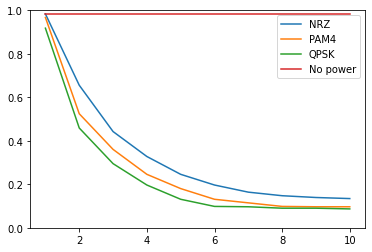

In [19]:
import numpy as np
from matplotlib import pyplot as plt
x = list(range(1, 11, 1))
y1 = np.array([6,4,2.7,2,1.5,1.2,1,0.9,0.85,0.82])/6.1
y3 = np.array([5.6,2.8,1.8,1.2,0.8,0.6,0.59,0.55,0.55,0.53])/6.1
y2 = np.array([5.9,3.2,2.2,1.5,1.1,0.8,0.7,0.6,0.59,0.59])/6.1
y=[6/6.1]*10
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y)
plt.ylim(0,1)
plt.legend(["NRZ", "PAM4", "QPSK","No power"])


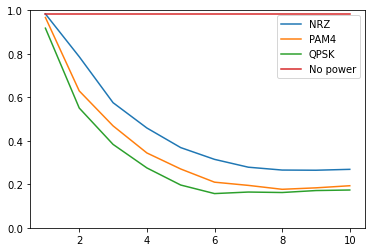

In [18]:
import numpy as np
from matplotlib import pyplot as plt
x = list(range(1, 11, 1))
y1 = np.multiply(np.array([6,4,2.7,2,1.5,1.2,1,0.9,0.85,0.82]), [1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2])/6.1
y3 = np.multiply(np.array([5.6,2.8,1.8,1.2,0.8,0.6,0.59,0.55,0.55,0.53]), [1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2])/6.1
y2 = np.multiply(np.array([5.9,3.2,2.2,1.5,1.1,0.8,0.7,0.6,0.59,0.59]), [1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2])/6.1
y=[6/6.1]*10
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y)
plt.ylim(0,1)
plt.legend(["NRZ", "PAM4", "QPSK","No power"])

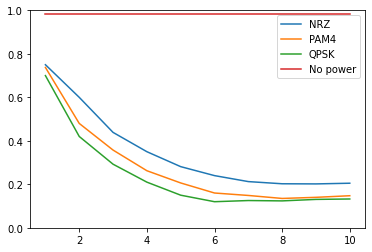

In [20]:
import numpy as np
from matplotlib import pyplot as plt
x = list(range(1, 11, 1))
y1 = np.multiply(np.array([6,4,2.7,2,1.5,1.2,1,0.9,0.85,0.82]), [1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2])/8
y3 = np.multiply(np.array([5.6,2.8,1.8,1.2,0.8,0.6,0.59,0.55,0.55,0.53]), [1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2])/8
y2 = np.multiply(np.array([5.9,3.2,2.2,1.5,1.1,0.8,0.7,0.6,0.59,0.59]), [1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2])/8
y=[6/6.1]*10
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y)
plt.ylim(0,1)
plt.legend(["NRZ", "PAM4", "QPSK","No power"])

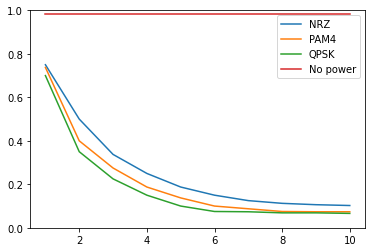

In [21]:
import numpy as np
from matplotlib import pyplot as plt
x = list(range(1, 11, 1))
y1 = np.array([6,4,2.7,2,1.5,1.2,1,0.9,0.85,0.82])/8
y3 = np.array([5.6,2.8,1.8,1.2,0.8,0.6,0.59,0.55,0.55,0.53])/8
y2 = np.array([5.9,3.2,2.2,1.5,1.1,0.8,0.7,0.6,0.59,0.59])/8
y=[6/6.1]*10
plt.plot(x,y1)
plt.plot(x,y2)
plt.plot(x,y3)
plt.plot(x,y)
plt.ylim(0,1)
plt.legend(["NRZ", "PAM4", "QPSK","No power"])


In [1]:
import numpy as np
import time
a = [1,2,3,4,5]
b = [6,7,8,9,0]
np.concatenate((a,b))

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

In [19]:
a = [0]*100000
# print(a)
b = [1]*100000
start = time.time()
for i in range(100):
    a.extend(b)
print(len(a), "time:", time.time()-start)

10100000 time: 0.09589695930480957


In [6]:
from src.components.optical_channel import ClassicalChannel
from src.kernel.timeline import Timeline
from src.topology.node import Node

params = {
    # Detector_parameters
    "collection_probability" : 0.5,
    # "dark_count_rate" : BSM_DET1_DARK, #100,
    # "dead_time" : 25000,
    # "time_resolution" : 50,

    # Optical channel
    "quantum_channel_attenuation" : 0.44,
    "classical_channel_attenuation" : 0.55,
    "distance" : 20, # Distance in km
    "raman_coefficient" : 10.5e-10, 
    # "max_rate" : 1e12,
    "quantum_channel_wavelength" : 1536e-9,
    "classical_channel_wavelength" : 1310e-9,
    "classical_communication_rate" : 1e10/1e12, # Classical communication (bit) rate in Picoseconds, i.e. B/ps. 1e7/1e12 is 10Mb/s in ps = 1e-5 b/ps

    "quantum_channel_index": 1.470,
    "classical_channel_index": 1.471,
    "classical_communication_window_size": (100/1e8)*1e12,

    # Light Source
    # "mean_photon_num" : 0.003, # 0.01

    # Classical channel parameters
    "avg_power": 2e-3, # avg_power is written in W
    "OMA": 1, # OMA is written in dBm
    "narrow_band_filter_bandwidth" : 0.03,
}
OMA = 10**( params["OMA"] /10)/1000 # We receive the OMA in dBm
assert params["avg_power"] - OMA/2 > 0
params["classical_powers"] = [params["avg_power"]-OMA/2, params["avg_power"]-OMA/6, params["avg_power"]+OMA/6, params["avg_power"]+OMA/2]

timeline = Timeline(1e12)
cc = ClassicalChannel("cc", timeline, 20, params)
sender0 = Node("sender0", timeline)
receiver1 = "receiver1"
cc.set_ends(sender0, receiver1)
cc.start_classical_communication()

Last bit is: 10000
directions: [False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False Fa

CompileException: /tmp/tmpv2p89qt_/86300b24da45d311ae1bf5d17c1b55dc29cb841e.cubin.cu(29): catastrophic error: cannot open source file "curand_kernel.h"

1 catastrophic error detected in the compilation of "/tmp/tmpv2p89qt_/86300b24da45d311ae1bf5d17c1b55dc29cb841e.cubin.cu".
Compilation terminated.


In [10]:
import numpy as np
a = np.array([[1,0,0],]).T
print(a.shape)
b = np.array([[1,1,1],])
print(b.shape)
a*b

(3, 1)
(1, 3)


array([[1, 1, 1],
       [0, 0, 0],
       [0, 0, 0]])

In [3]:
from src.kernel.quantum_utils import density_partial_trace
state = ((0,0,0,0),
         (0,0.5,0.5,0),
         (0,0.5,0.5,0),
         (0,0,0,0))

density_partial_trace(state, (0,), 2, 1)

array([[0.5, 0. ],
       [0. , 0.5]])

In [1]:
from src.components.memory import AbsorptiveMemory
from src.kernel.timeline import Timeline

tl = Timeline(1e12)

# def efficiency(time):
#     return time*2

efficiency = lambda time: time*2


a = AbsorptiveMemory("mem", tl, frequency=1e8,
                    absorption_efficiency=0.5, afc_efficiency=efficiency,
                    mode_number=100, wavelength=1550, destination="meas")
a.pickle_funct()
1==2

AttributeError: 'AbsorptiveMemory' object has no attribute 'pickle_funct'

In [13]:
import numpy as np
from copy import copy

def build_bell_state(truncation, sign, phase=0, formalism="dm"):
    """Generate standard Bell state which is heralded in ideal BSM.

    For comparison with results from imperfect parameter choices.
    """

    basis0 = np.zeros(truncation+1)
    basis0[0] = 1
    basis1 = np.zeros(truncation+1)
    basis1[1] = 1
    basis10 = np.kron(basis1, basis0)
    basis01 = np.kron(basis0, basis1)
    
    if sign == "plus":
        ket = (basis10 + np.exp(1j*phase)*basis01)/np.sqrt(2)
    elif sign == "minus":
        ket = (basis10 - np.exp(1j*phase)*basis01)/np.sqrt(2)
    else:
        raise ValueError("Invalid Bell state sign type " + sign)

    dm = np.outer(ket, ket.conj())

    if formalism == "dm":
        return dm
    elif formalism == "ket":
        return ket
    else:
        raise ValueError("Invalid quantum state formalism " + formalism)


def effective_state(state):
    state_copy = copy(state)
    state_copy[0][0] = 0
    state_copy = state_copy/np.trace(state_copy)
    
    return state_copy


def calculate_fidelity(bins, off_diag):
    reconstructed_state = np.zeros((4,4), np.cdouble)
    for i in range(4):
        reconstructed_state[i,i] = bins[i]
    reconstructed_state[1,2] = reconstructed_state[2,1] = off_diag

    
    remaining_state_eff = effective_state(reconstructed_state)

    print("remaining_state_eff:\n", remaining_state_eff)

    # calculate the fidelity with reference Bell state
    bell_minus = build_bell_state(1, "minus")
    # bell_minus = build_bell_state(1, "minus")
    # print("bell_plus state:")
    # print(bell_plus)

    print("bell_minus state:")
    print(bell_minus)

    fidelity = np.trace(remaining_state_eff.dot(bell_minus)).real


    print(fidelity)



calculate_fidelity([0.6, 0.17, 0.17, 0.008], 0.16)


remaining_state_eff:
 [[0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.48850575+0.j 0.45977011+0.j 0.        +0.j]
 [0.        +0.j 0.45977011+0.j 0.48850575+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.02298851+0.j]]
bell_minus state:
[[ 0. +0.j  0. -0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0.5+0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j -0.5-0.j  0.5+0.j  0. +0.j]
 [ 0. +0.j  0. -0.j  0. +0.j  0. +0.j]]
0.028735632183908063


In [10]:
import re
pattern = "\d[.]?\d*"
text = "params0.05500000000000001_5.json"
re.findall(pattern, text)


['0.05500000000000001', '5.']